In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.offline as py
import plotly.graph_objs as go
import nltk
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
zomato_data=pd.read_csv("zomato.csv")
zomato_df=zomato_data.copy()
zomato_df.head(2)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari


In [12]:
zomato_df.shape

(51717, 17)

In [13]:
zomato_df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

In [14]:
zomato_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [15]:
zomato_df.isnull().sum()

url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7775
votes                              0
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [16]:
# Drop unnecessary columns
zomato_df = zomato_df.drop(['phone', 'dish_liked', 'url'], axis=1, errors='ignore')

zomato_df.dropna(how='any', inplace=True)

print("Number of duplicates before removal:", zomato_df.duplicated().sum())
zomato_df.drop_duplicates(inplace=True)

zomato_df = zomato_df.rename(columns={
    'approx_cost(for two people)': 'cost',
    'listed_in(type)': 'type',
    'listed_in(city)': 'city'
})

zomato_df = zomato_df[~zomato_df['rate'].isin(['NEW', '-'])].reset_index(drop=True)

zomato_df['rate'] = (
    zomato_df['rate']
    .str.replace('/5', '')  # Remove '/5' if present
    .str.strip()            # Remove whitespace
    .astype(float)          # Convert to float
)

zomato_df['cost'] = (
    zomato_df['cost']
    .astype(str)
    .str.replace(',', '.')  
    .astype(float)
)

Number of duplicates before removal: 34


In [18]:
# Computing Mean Rating
restaurants = list(zomato_df['name'].unique())
zomato_df['Mean Rating'] = 0.0

for restaurant in restaurants:
    # Calculate mean rating for each restaurant
    mean_rating = zomato_df.loc[zomato_df['name'] == restaurant, 'rate'].mean()
    # Assign the mean rating to all rows for this restaurant
    zomato_df.loc[zomato_df['name'] == restaurant, 'Mean Rating'] = mean_rating

# Scaling the mean rating values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(1, 5))
zomato_df[['Mean Rating']] = scaler.fit_transform(zomato_df[['Mean Rating']]).round(2)

# Checking the mean rating with restaurant name and rating
print(zomato_df[['name', 'rate', 'Mean Rating']].head())

                    name  rate  Mean Rating
0                  Jalsa   4.1         3.99
1         Spice Elephant   4.1         3.97
2        San Churro Cafe   3.8         3.58
3  Addhuri Udupi Bhojana   3.7         3.45
4          Grand Village   3.8         3.58


In [16]:
# Descriptive statistics for numerical columns
print("\nDescriptive statistics for numerical columns:")
print(zomato_df[numerical_cols].describe())


Descriptive statistics for numerical columns:
               rate         votes          cost   Mean Rating
count  41237.000000  41237.000000  41237.000000  41237.000000
mean       3.702030    352.772001    369.586259      3.454193
std        0.440034    884.409230    242.522954      0.537738
min        1.800000      0.000000      1.000000      1.000000
25%        3.400000     21.000000    200.000000      3.060000
50%        3.700000     73.000000    400.000000      3.450000
75%        4.000000    277.000000    500.000000      3.840000
max        4.900000  16832.000000    950.000000      5.000000


In [17]:
zomato_df.isnull().sum()

address         0
name            0
online_order    0
book_table      0
rate            0
votes           0
location        0
rest_type       0
cuisines        0
cost            0
reviews_list    0
menu_item       0
type            0
city            0
dtype: int64

In [19]:
numerical_cols = zomato_df.select_dtypes(include=np.number).columns.tolist()
print("\nNumerical columns:")
print(numerical_cols)


Numerical columns:
['rate', 'votes', 'cost', 'Mean Rating']


In [20]:
# Identify Categorical columns
categorical_cols = zomato_df.select_dtypes(include='object').columns.tolist()
print("\nCategorical columns:")
print(categorical_cols)


Categorical columns:
['address', 'name', 'online_order', 'book_table', 'location', 'rest_type', 'cuisines', 'reviews_list', 'menu_item', 'type', 'city']


In [21]:
#We will be using the 'Review' and 'Cuisines' feature in order to create a recommender system
## Lower Casing
zomato_df['reviews_list'] = zomato_df['reviews_list'].str.lower()

## Removal of Punctuations
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
zomato_df['reviews_list'] = zomato_df['reviews_list'].apply(lambda text: remove_punctuation(text))

In [22]:
zomato_df[['reviews_list', 'cuisines']].sample(5)

,reviews_list,cuisines
8224,rated 50 ratedn today ordered a quick snack m...,"Cafe, Beverages, Fast Food, Street Food"
3122,rated 40 ratedn whats special about behrouz n...,Biryani
16848,rated 40 ratedn this visit was long pending i...,South Indian
11457,rated 50 ratedn hands down this is the best p...,"Continental, Mexican, Burger, Desserts, Italia..."
25735,rated 20 ratedn finnally i have burger in thi...,Burger



--- Step 4: Outlier Detection (using Box Plots) ---


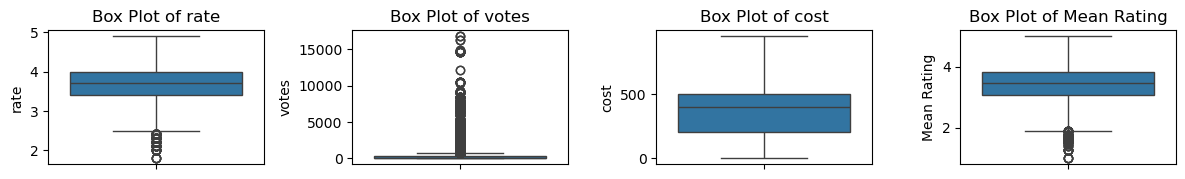

In [23]:
print("\n--- Step 4: Outlier Detection (using Box Plots) ---")

plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols):
    plt.subplot(5, 5, i + 1) # Adjust subplot grid based on number of numerical columns
    sns.boxplot(y=zomato_df[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Number of outlets')

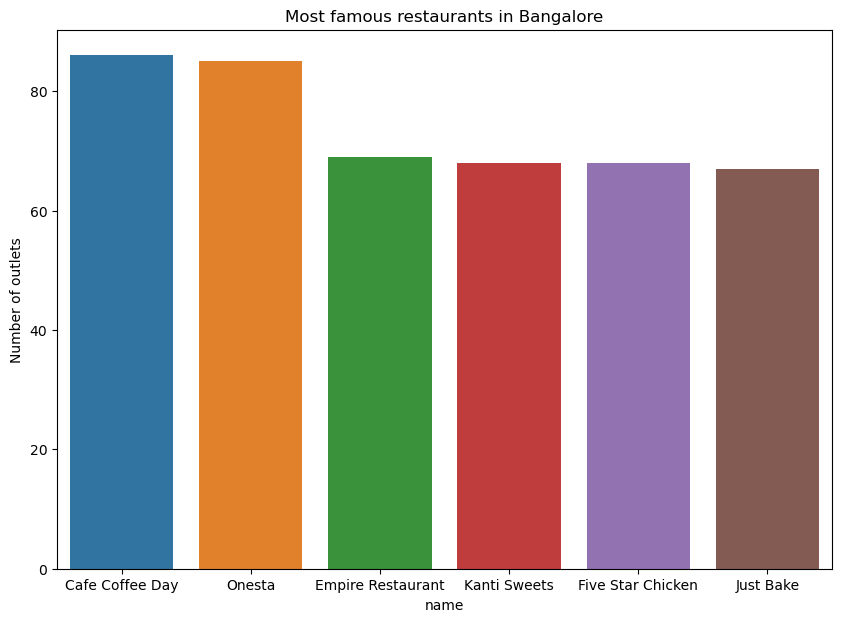

In [24]:
plt.figure(figsize=(10,7))
chains = zomato_df['name'].value_counts()[:6].reset_index()
chains.columns = ['name', 'count']
sns.barplot(data=chains, x='name', y='count', hue='name', dodge=False, palette='tab10', legend=False)
plt.title("Most famous restaurants in Bangalore")
plt.ylabel("Number of outlets")


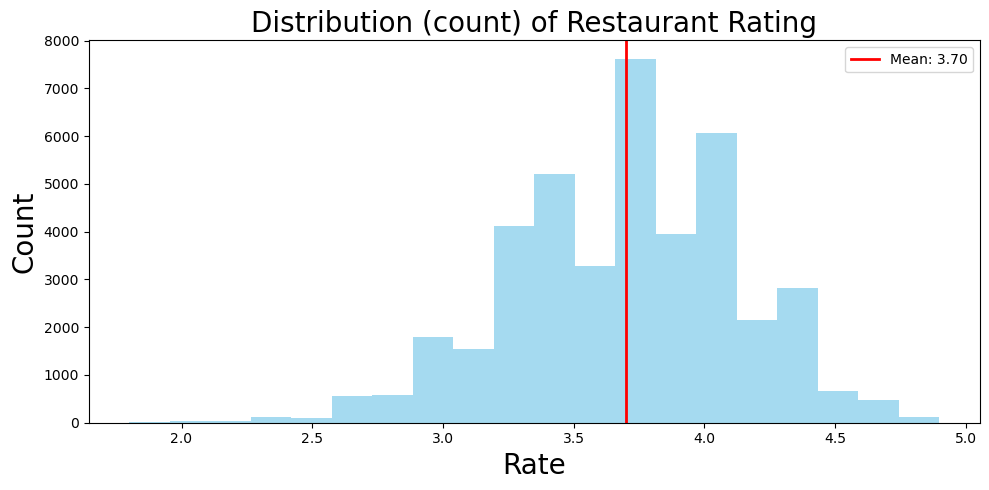

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# Plot histogram of the 'rate' column
sns.histplot(zomato_df['rate'], bins=20, color='skyblue',edgecolor=None, ax=ax)

# Plot a vertical line for the mean
mean_rating = zomato_df['rate'].mean()
ax.axvline(mean_rating, color='red', linewidth=2, label=f'Mean: {mean_rating:.2f}')

# Add legend, labels, and title
ax.legend()
ax.set_xlabel('Rate', size=20)
ax.set_ylabel('Count', size=20)
ax.set_title('Distribution (count) of Restaurant Rating', size=20)

# Display the plot
plt.tight_layout()
plt.show()


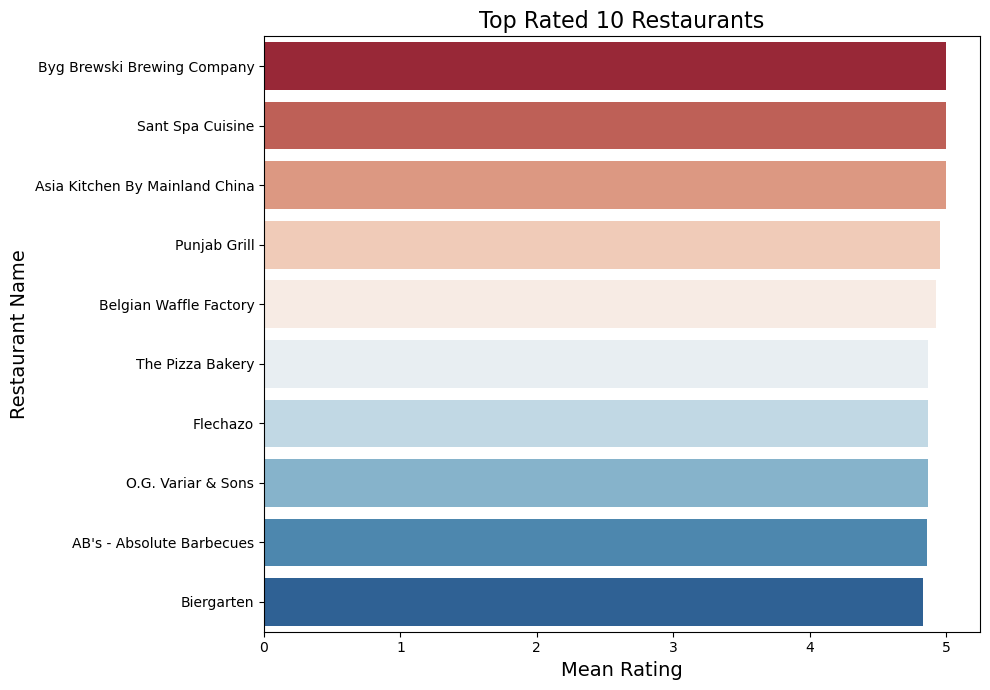

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use a font that supports more Unicode characters to avoid glyph warnings
plt.rcParams['font.family'] = 'DejaVu Sans'

# Optional: Clean restaurant names to remove problematic non-ASCII characters
zomato_df['name'] = zomato_df['name'].apply(lambda x: x.encode('ascii', 'ignore').decode())

# Get top 10 rated restaurants
df_rating = zomato_df.drop_duplicates(subset='name')
df_rating = df_rating.sort_values(by='Mean Rating', ascending=False).head(10)

# Set figure size
plt.figure(figsize=(10, 7))

# Barplot
sns.barplot(data=df_rating, x='Mean Rating', y='name', palette='RdBu', legend=False,hue='name')

# Title and axis labels
plt.title('Top Rated 10 Restaurants', fontsize=16)
plt.xlabel('Mean Rating', fontsize=14)
plt.ylabel('Restaurant Name', fontsize=14)

# Improve layout
plt.tight_layout()

# Show plot
plt.show()


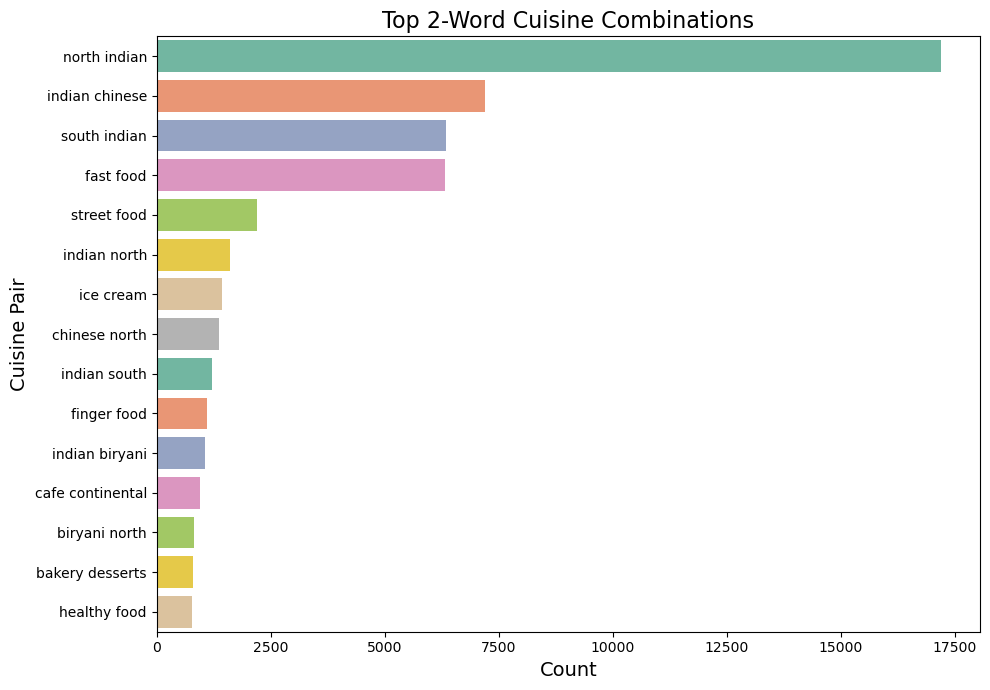

In [27]:
# Sample implementation of get_top_words
def get_top_words(text_series, top_n=15, ngram_range=(2, 2)):
    """Extract top n most frequent n-grams from a pandas Series of text data"""
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    bag_of_words = vec.fit_transform(text_series.fillna(''))
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]

# Assuming zomato_df is your DataFrame and 'cuisines' is a column in it
lst = get_top_words(zomato_df['cuisines'], top_n=15, ngram_range=(2, 2))
df_words = pd.DataFrame(lst, columns=['Word', 'Count'])

# Plotting
plt.figure(figsize=(10, 7))
sns.barplot(data=df_words, x='Count', y='Word',hue='Word', palette='Set2',legend=False)  
plt.title('Top 2-Word Cuisine Combinations', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Cuisine Pair', fontsize=14)
plt.tight_layout()
plt.show()


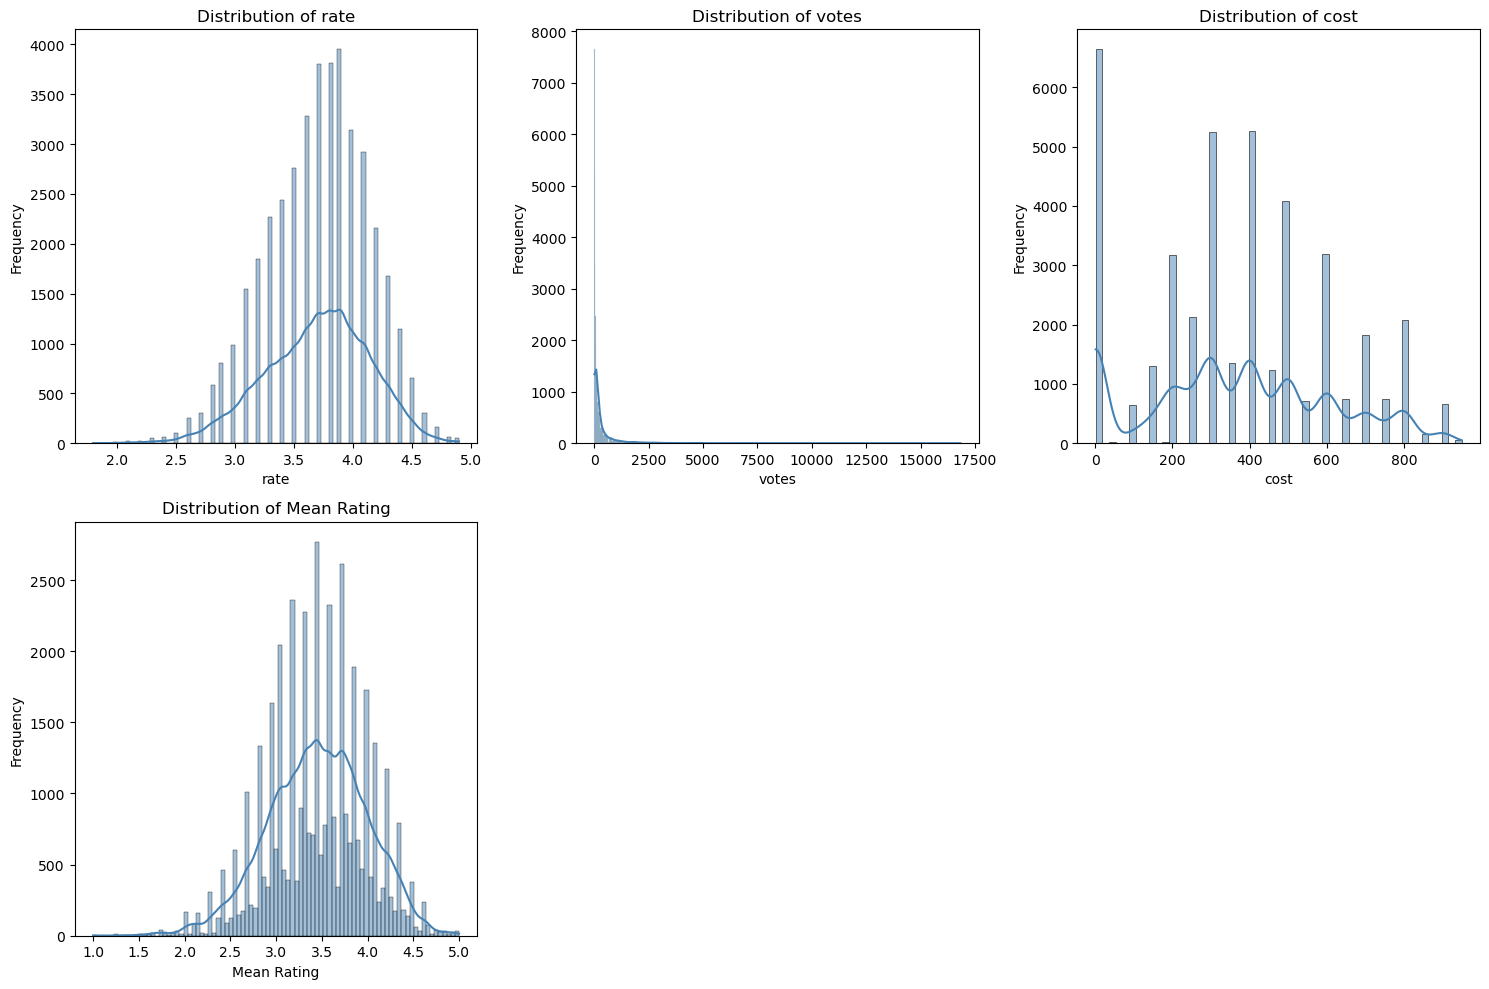

In [28]:
#numerical cols analysis
numerical_cols = zomato_df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(15, 10))  # Bigger, more readable
for i, col in enumerate(numerical_cols):
    plt.subplot((len(numerical_cols) + 2) // 3, 3, i + 1)  # Dynamic rows, 3 columns
    sns.histplot(zomato_df[col], kde=True, color='steelblue', edgecolor='black')  # Styled
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


Bar plots for categorical columns:


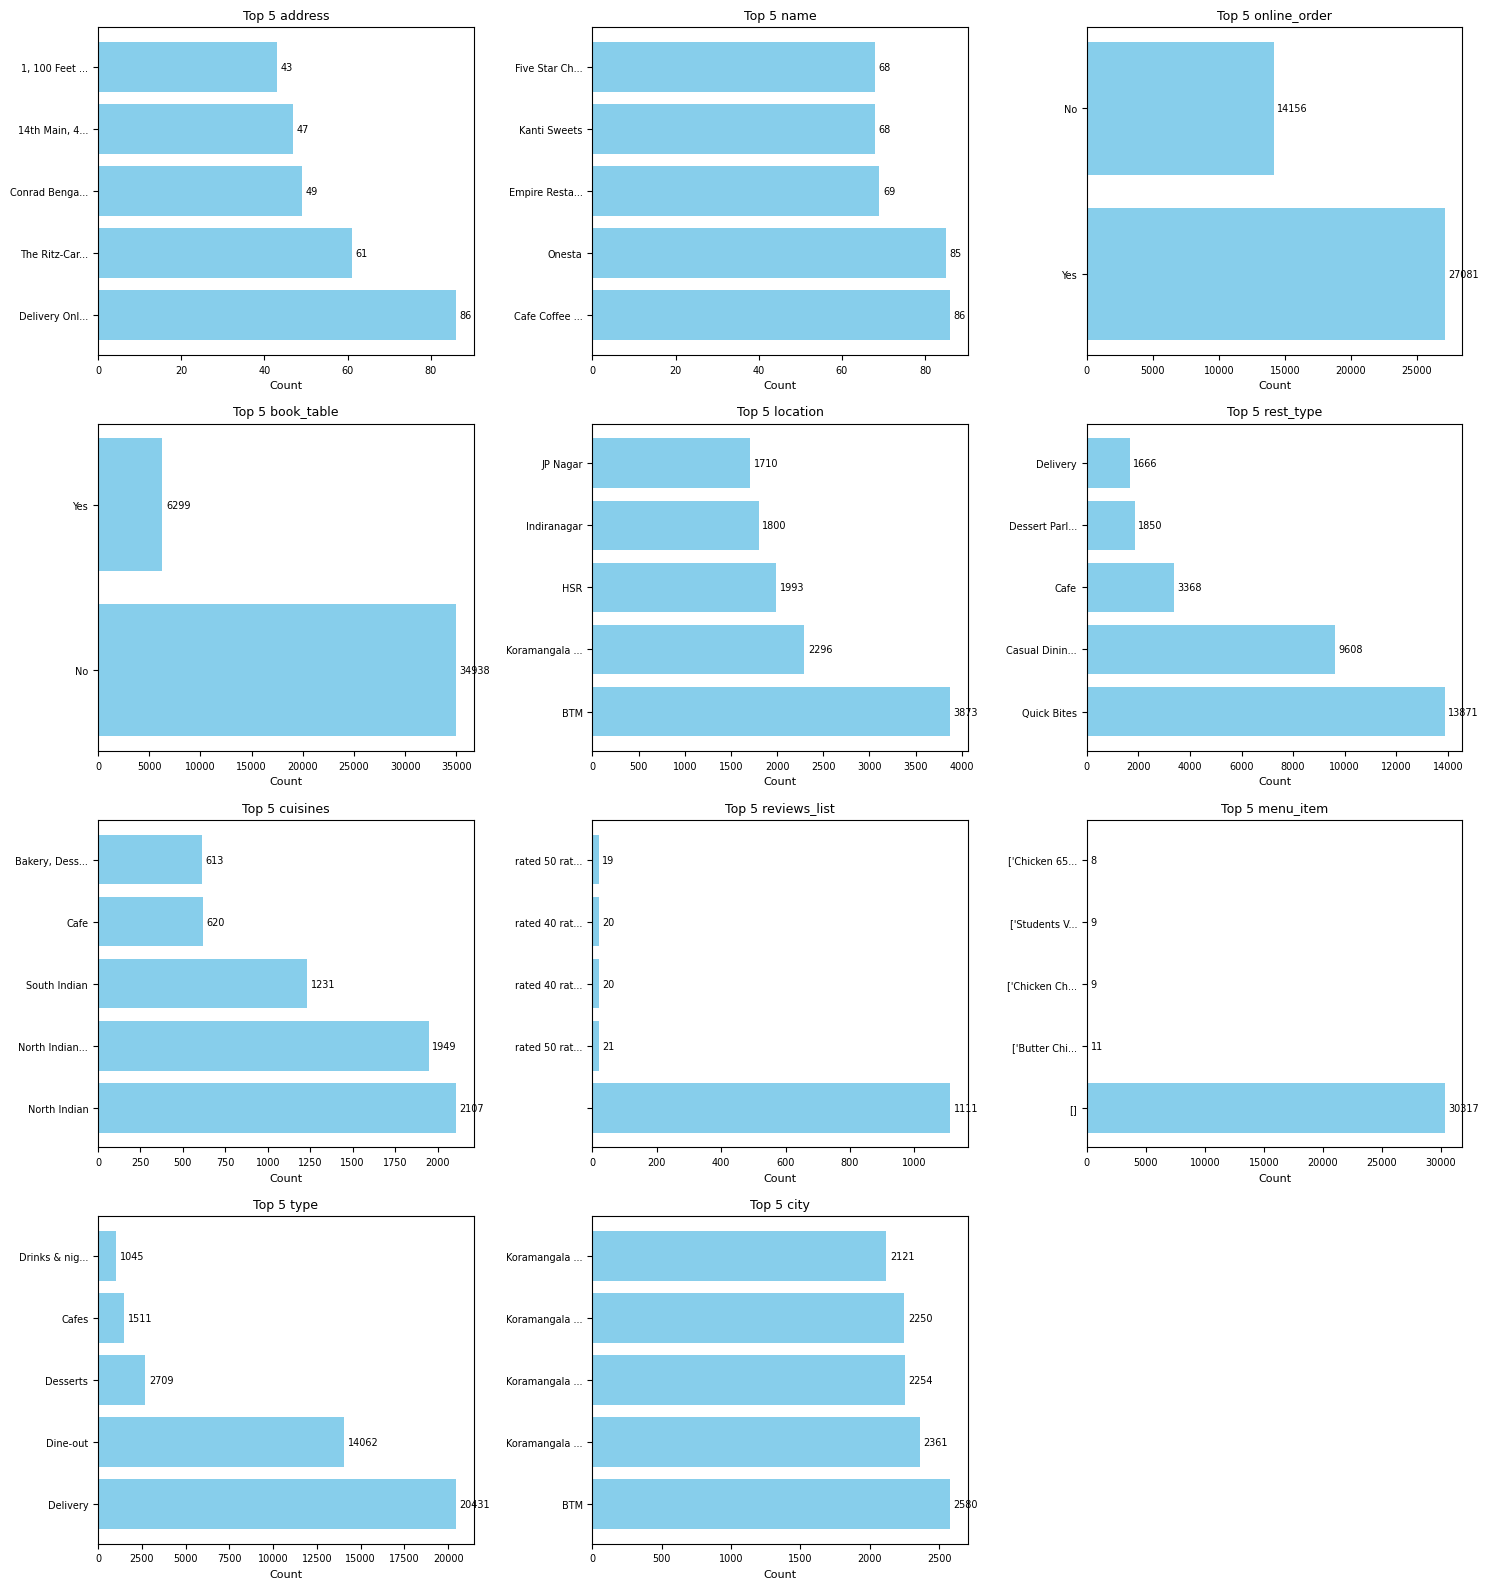

In [29]:
#Categorical Analysis
categorical_cols = zomato_df.select_dtypes(include=['object']).columns

def truncate_text(text, max_length=15):
    """Truncate text if it's too long and handle NaN values"""
    if pd.isna(text):
        return 'Unknown'
    text_str = str(text)
    return text_str[:max_length] + '...' if len(text_str) > max_length else text_str
print("\nBar plots for categorical columns:")
if len(categorical_cols) == 0:
    print("No categorical columns found!")
else:
    n_cols = min(3, len(categorical_cols))  # Max 3 columns
    n_rows = (len(categorical_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(15, 4 * n_rows))  # Smaller, more manageable size
    
    for i, col in enumerate(categorical_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # Get top 5 categories
        top_categories = zomato_df[col].value_counts().head(5)
        truncated_categories = [truncate_text(cat, 12) for cat in top_categories.index]
        
        # Create simple bar plot (not seaborn countplot)
        plt.barh(range(len(top_categories)), top_categories.values, color='skyblue')
        plt.yticks(range(len(top_categories)), truncated_categories, fontsize=8)
        plt.xlabel('Count', fontsize=8)
        plt.title(f'Top 5 {col}', fontsize=9)
        plt.gca().tick_params(axis='both', which='major', labelsize=7)
        for j, v in enumerate(top_categories.values):
            plt.text(v + max(top_categories.values) * 0.01, j, str(v), 
                    va='center', fontsize=7)
    
    plt.tight_layout() 
    plt.show()

Numerical vs. Numerical:

Correlation Matrix:
                 rate     votes      cost  Mean Rating
rate         1.000000  0.435237 -0.115346     0.946892
votes        0.435237  1.000000 -0.116118     0.437955
cost        -0.115346 -0.116118  1.000000    -0.122350
Mean Rating  0.946892  0.437955 -0.122350     1.000000


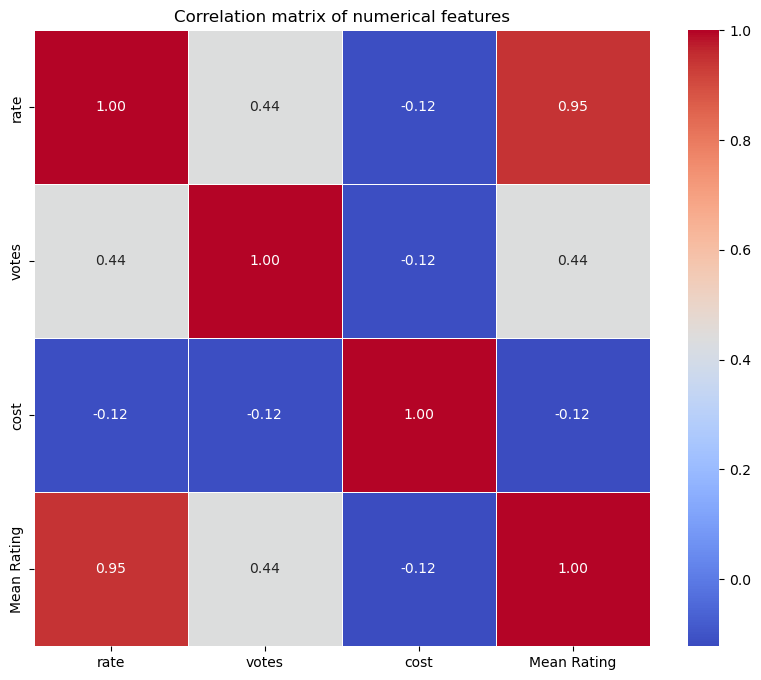

In [30]:
#Numerical vs Numerical
print("Numerical vs. Numerical:")
print("\nCorrelation Matrix:")
corr_matrix = zomato_df[numerical_cols].corr()
print(corr_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Correlation matrix of numerical features')
plt.show()

Pairplot:


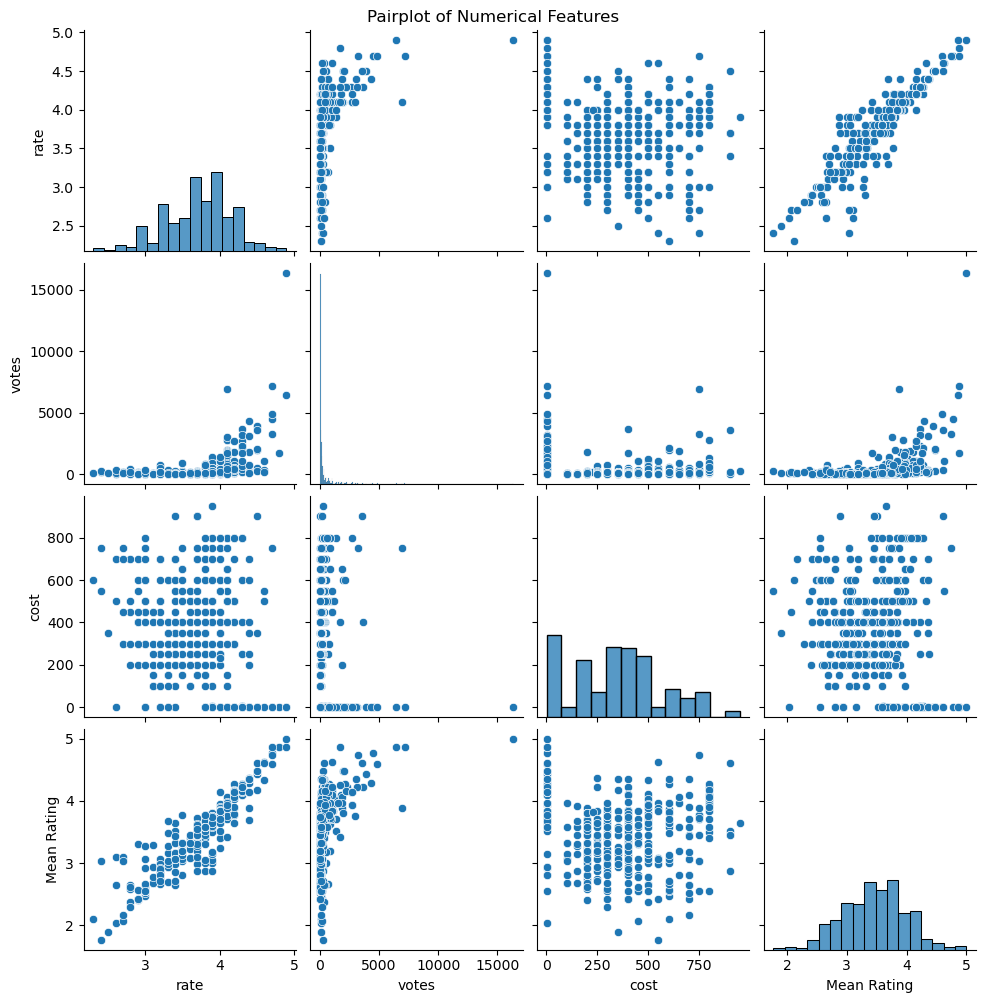

In [31]:
#Pairplot for scatterplots
print("Pairplot:")
sns.pairplot(zomato_df[numerical_cols].sample(500))
plt.suptitle('Pairplot of Numerical Features',y=1.0) #y is set to maintain the height between the title and plots(vertically)
plt.show()

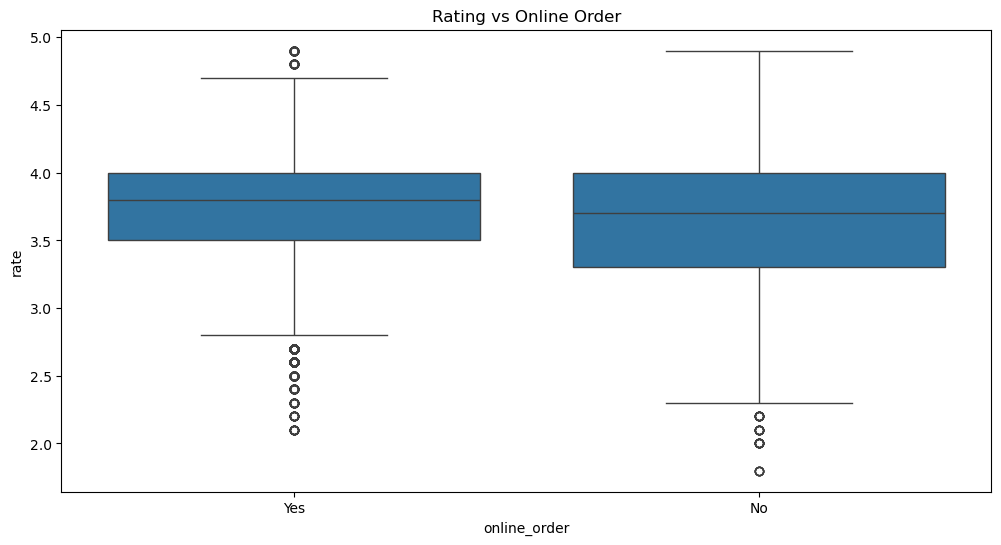

In [32]:
#Rating vs online_order-to analyse whether the rating is influenced by the point that online order is offered or not
plt.figure(figsize=(12, 6))
sns.boxplot(x='online_order', y='rate', data=zomato_df)
plt.title('Rating vs Online Order')
plt.show()

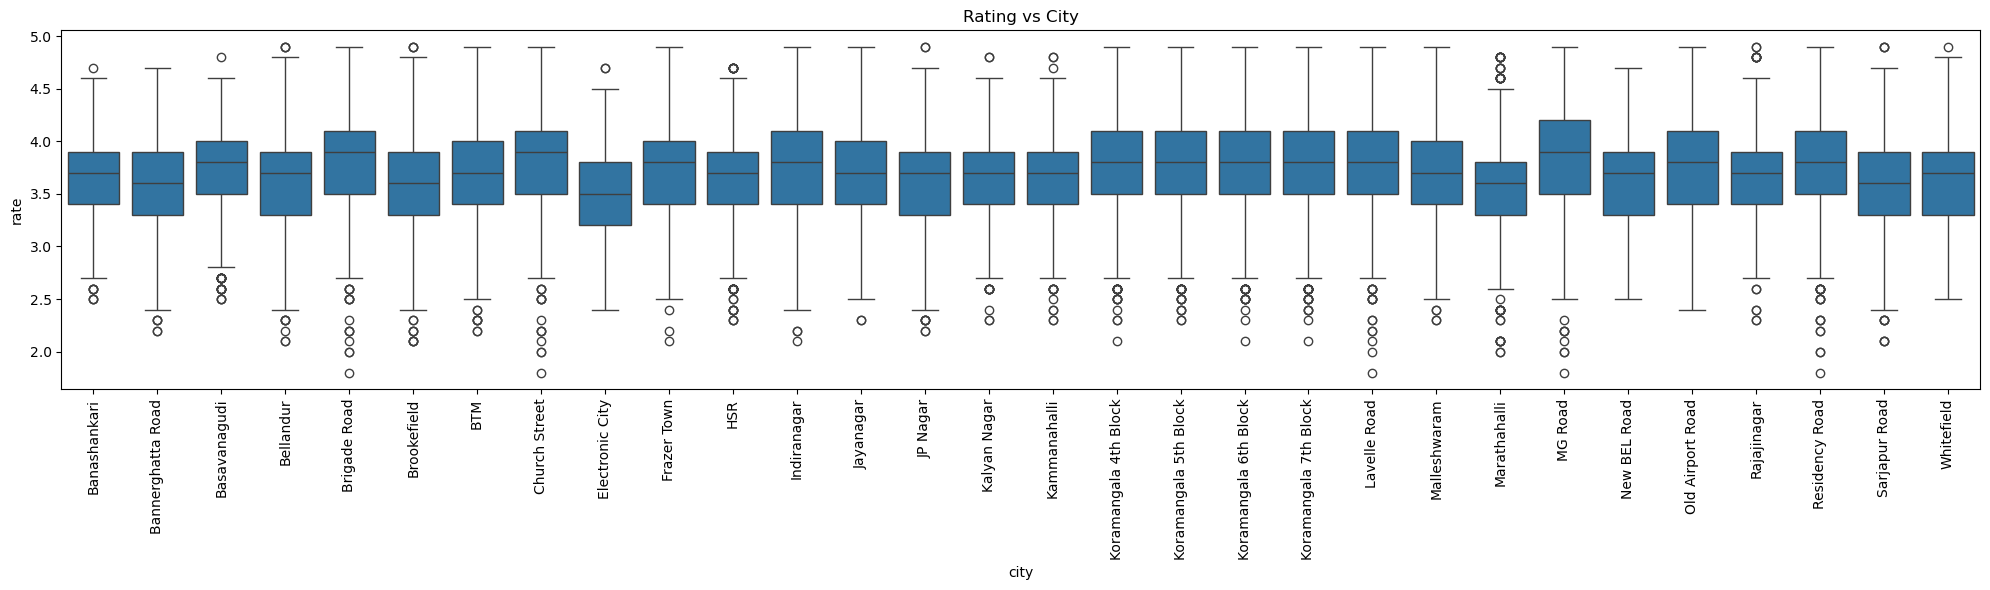

In [33]:
#rating vs city-if restuarant ratings vary accross cities
plt.figure(figsize=(20, 6))
sns.boxplot(x='city', y='rate', data=zomato_df)
plt.title('Rating vs City')
plt.xticks(rotation='vertical')  #making the labels vertical so that the labels don't overlap
plt.tight_layout()
plt.show()

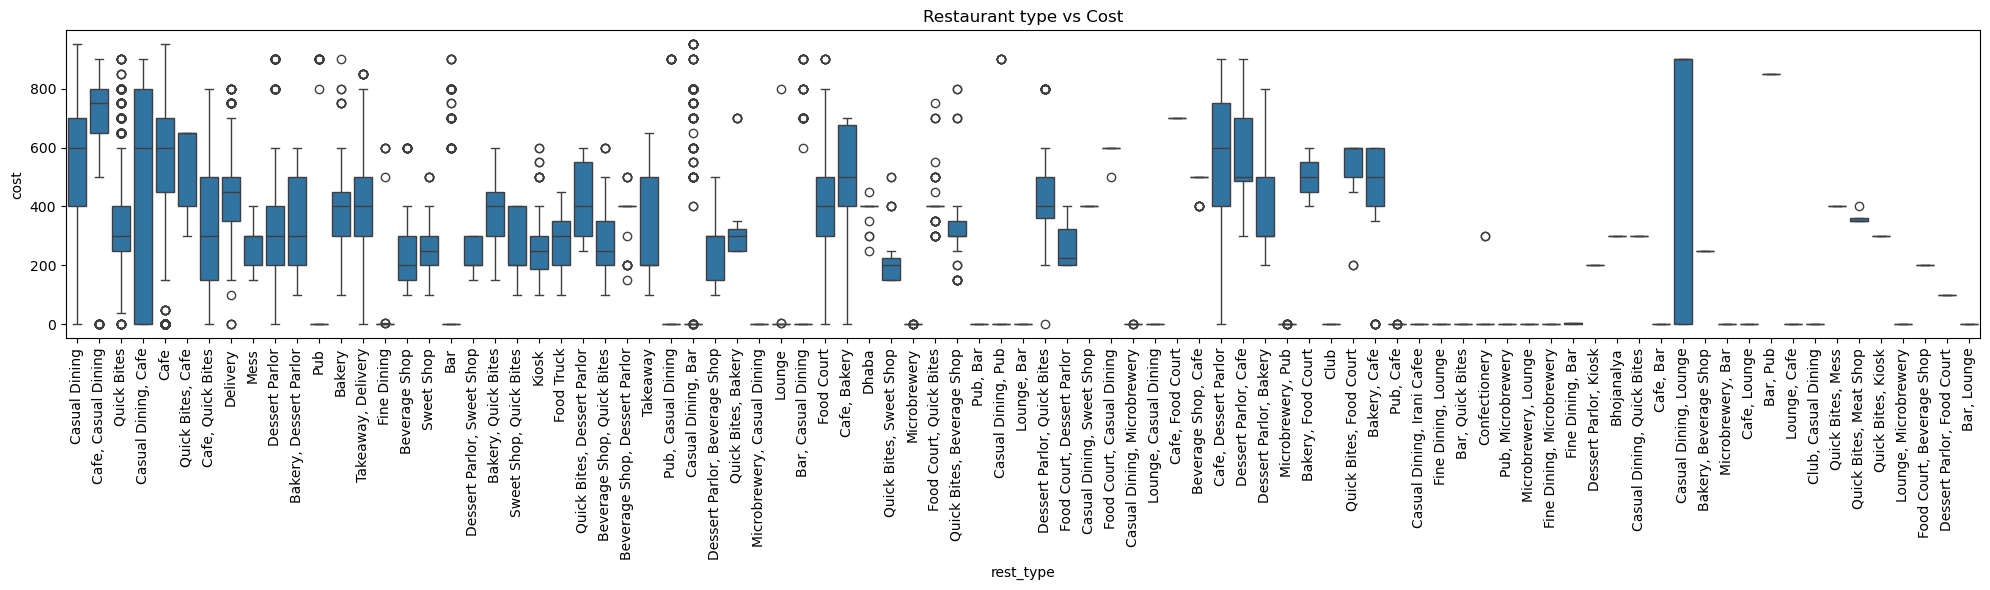

In [34]:
#rest_type vs cost- How cost to eat varies accross diff types of restuarants
plt.figure(figsize=(20, 6))
sns.boxplot(x='rest_type', y='cost', data=zomato_df)
plt.title('Restaurant type vs Cost')
plt.xticks(rotation='vertical')  #making the labels vertical so that the labels don't overlap
plt.tight_layout()
plt.show()

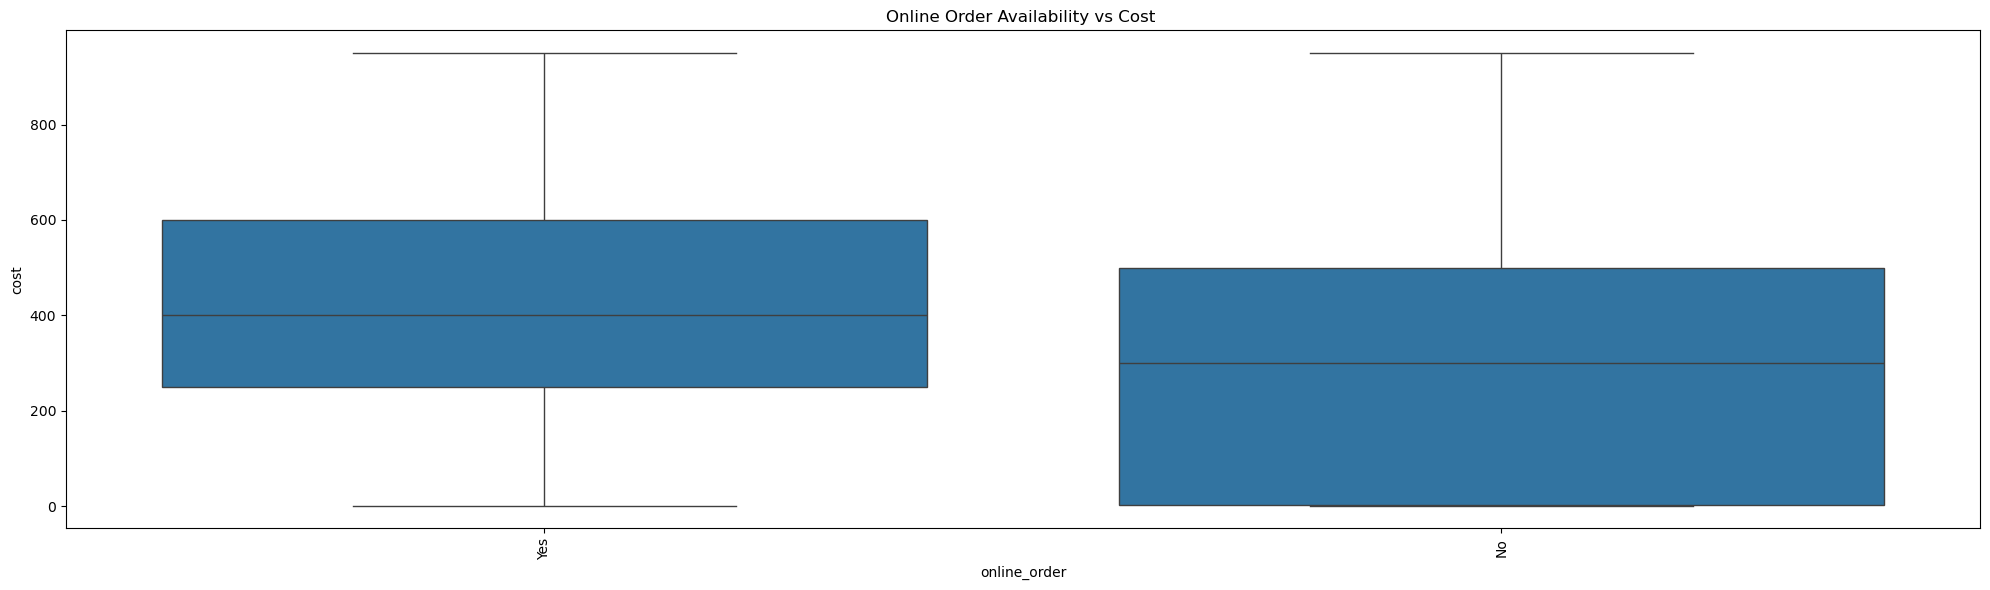

In [35]:
#Online Order Availability vs Cost- If restaurants offering online delivery services tend to be cheaper or costlier
plt.figure(figsize=(20, 6))
sns.boxplot(x='online_order', y='cost', data=zomato_df)
plt.title('Online Order Availability vs Cost ')
plt.xticks(rotation='vertical')  #making the labels vertical so that the labels don't overlap
plt.tight_layout()
plt.show()

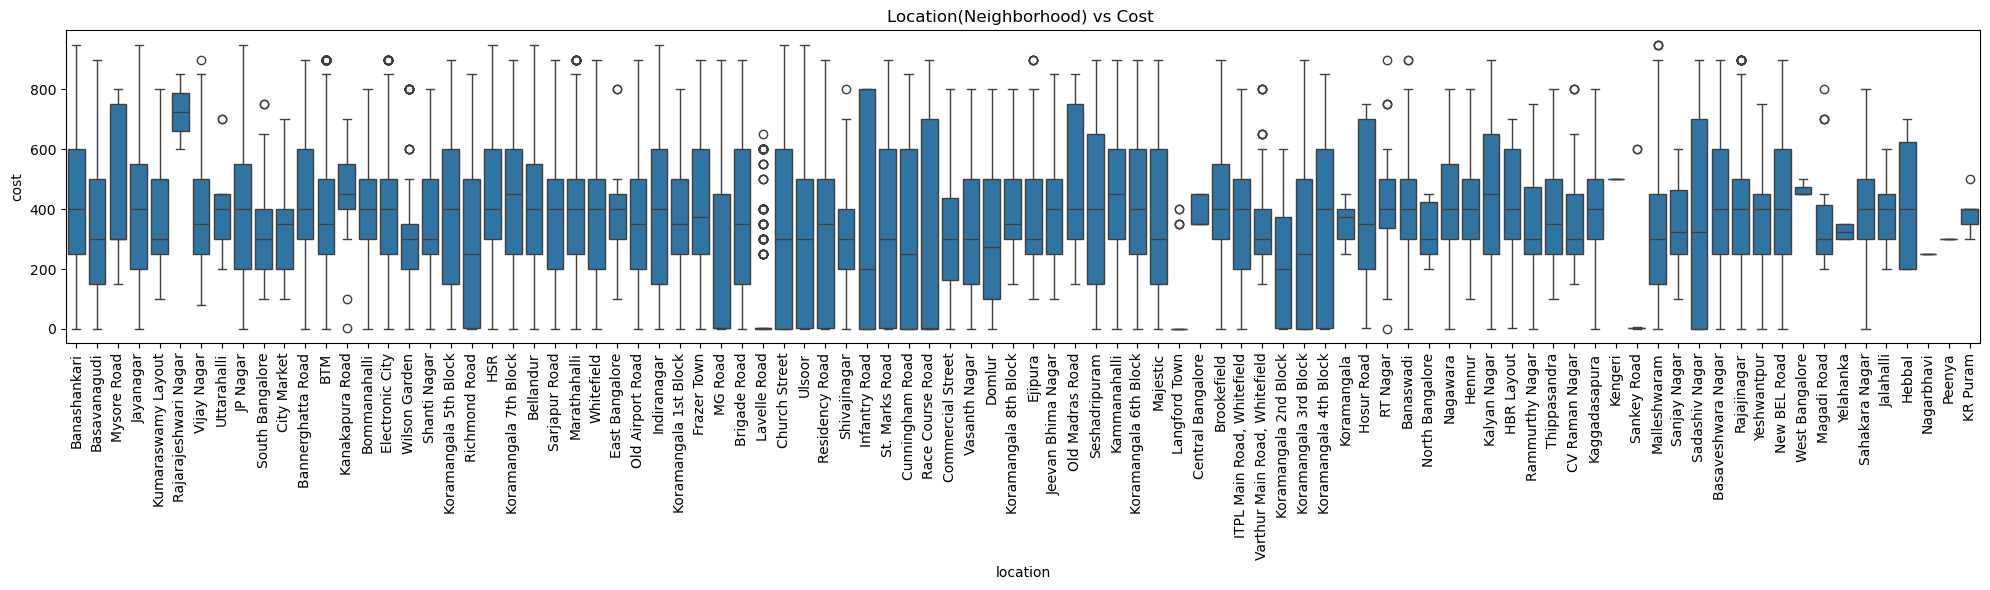

In [36]:
#location vs cost
plt.figure(figsize=(20, 6))
sns.boxplot(x='location', y='cost', data=zomato_df)
plt.title('Location(Neighborhood) vs Cost ')
plt.xticks(rotation='vertical')  #making the labels vertical so that the labels don't overlap
plt.tight_layout()
plt.show()

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Buffet'),
  Text(1, 0, 'Cafes'),
  Text(2, 0, 'Delivery'),
  Text(3, 0, 'Desserts'),
  Text(4, 0, 'Dine-out'),
  Text(5, 0, 'Drinks & nightlife'),
  Text(6, 0, 'Pubs and bars')])

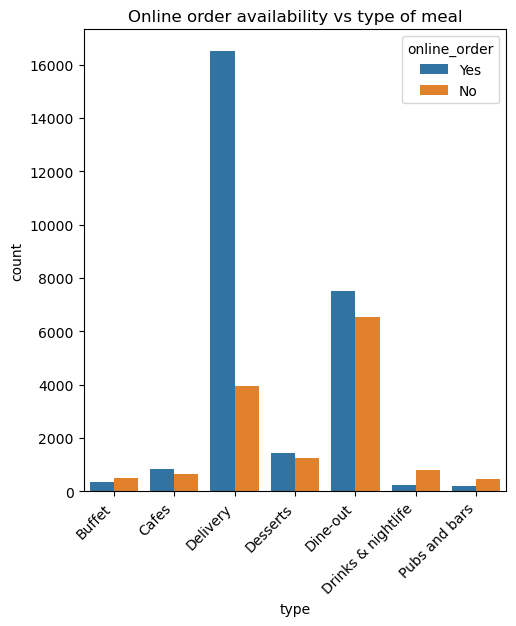

In [37]:
#online order vs type of meal-online ordering is more common in which type of restaurants 
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=zomato_df, x='type', hue='online_order')
plt.title('Online order availability vs type of meal')
plt.xticks(rotation=45, ha='right')


Cross-tabulation: Table booking option vs location
location     BTM  Banashankari  Banaswadi  Bannerghatta Road  Basavanagudi  \
book_table                                                                   
No          3719           691        460               1128           579   
Yes          154            53          8                 98            16   

location    Basaveshwara Nagar  Bellandur  Bommanahalli  Brigade Road  \
book_table                                                              
No                         115        899           141           878   
Yes                         18         98             3           174   

location    Brookefield  ...  Ulsoor  Uttarahalli  \
book_table               ...                        
No                  471  ...     669            9   
Yes                  72  ...     177            0   

location    Varthur Main Road, Whitefield  Vasanth Nagar  Vijay Nagar  \
book_table                                              

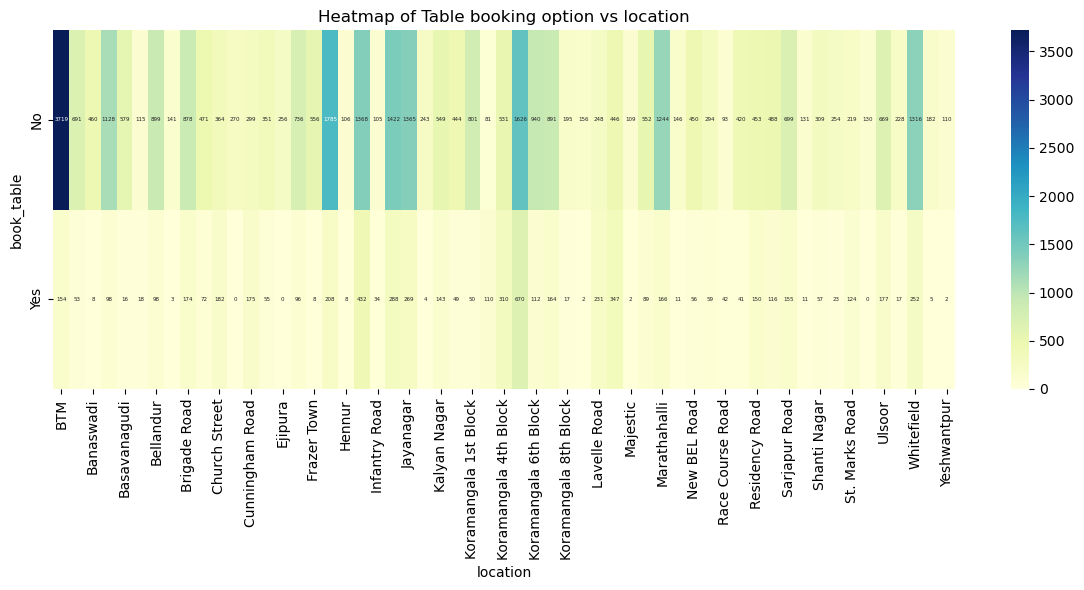

In [38]:
plt.figure(figsize=(12, 6))
print("\nCross-tabulation: Table booking option vs location")
rest_type_crosstab= pd.crosstab(zomato_df['book_table'], zomato_df['location'])
print(rest_type_crosstab)
filtered_crosstab = rest_type_crosstab.loc[:, rest_type_crosstab.sum() >= 100]
sns.heatmap(filtered_crosstab, annot=True,annot_kws={"size": 4},fmt='d', cmap='YlGnBu')
plt.title('Heatmap of Table booking option vs location')
plt.tight_layout()
plt.show()

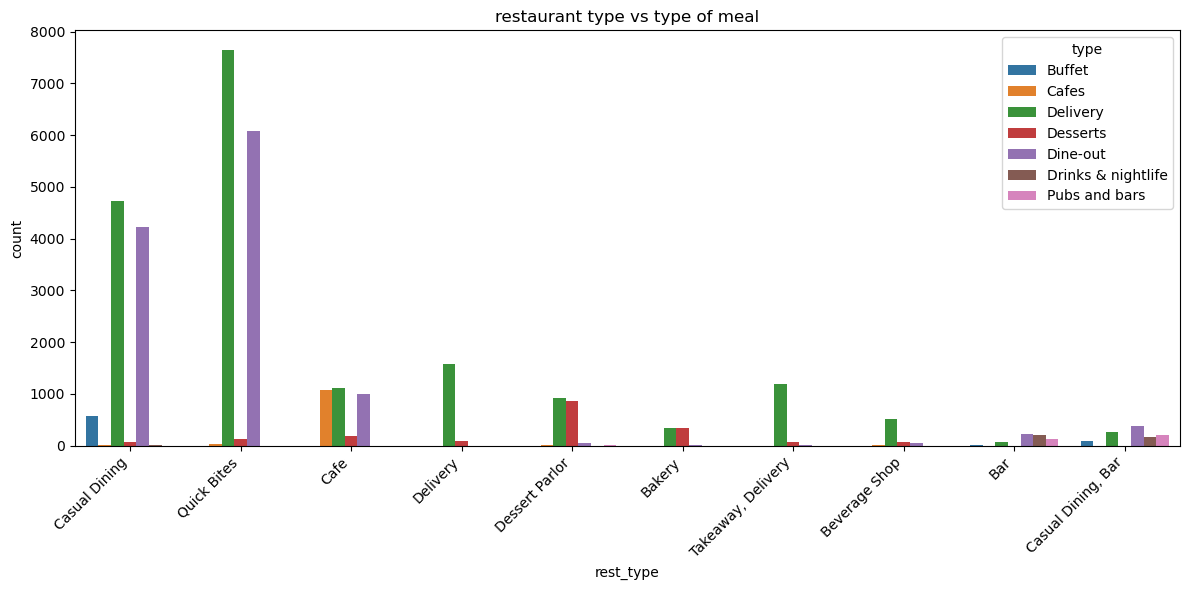

In [39]:
#only include rows where the rest_type is among the top 10 most common types.
top_rest_types = zomato_df['rest_type'].value_counts().nlargest(10).index
filtered_df = zomato_df[zomato_df['rest_type'].isin(top_rest_types)]
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df, x='rest_type', hue='type')
plt.title('restaurant type vs type of meal')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Cost by Rest Type, broken down by Online Order:


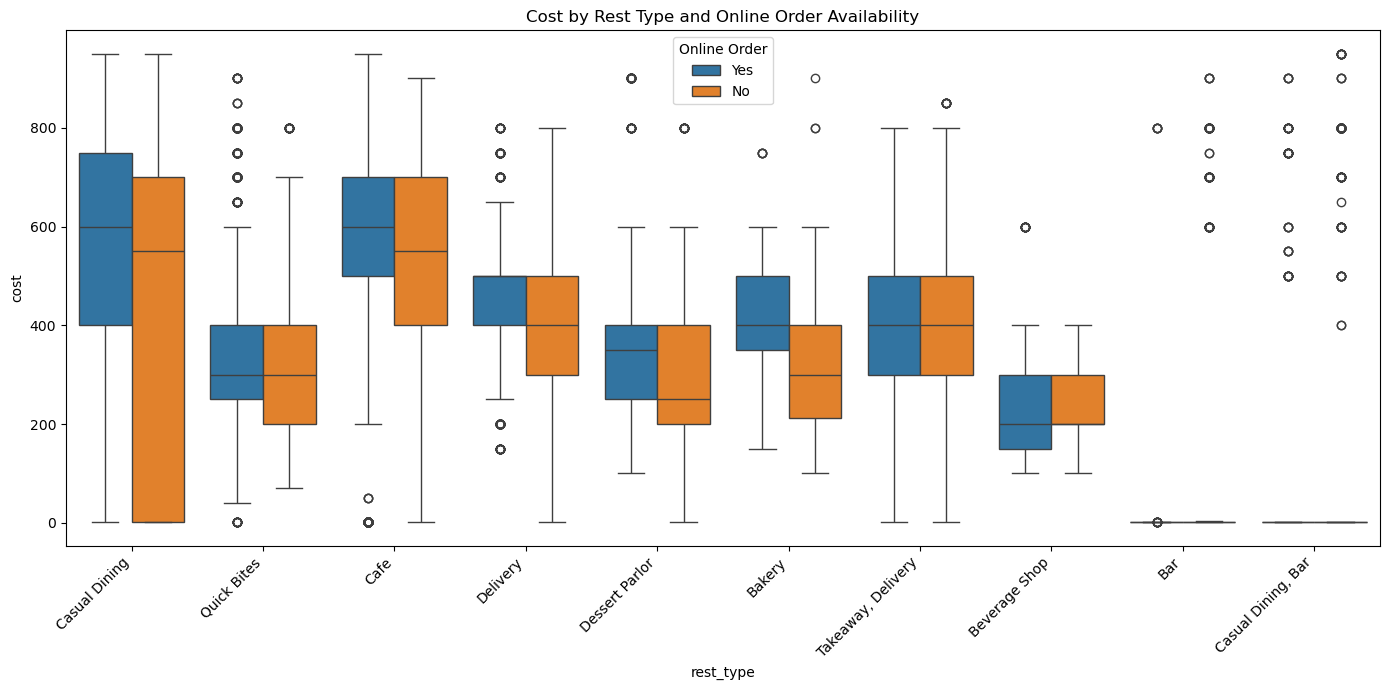


Votes vs Cost, separated by Online Order and colored by Type:


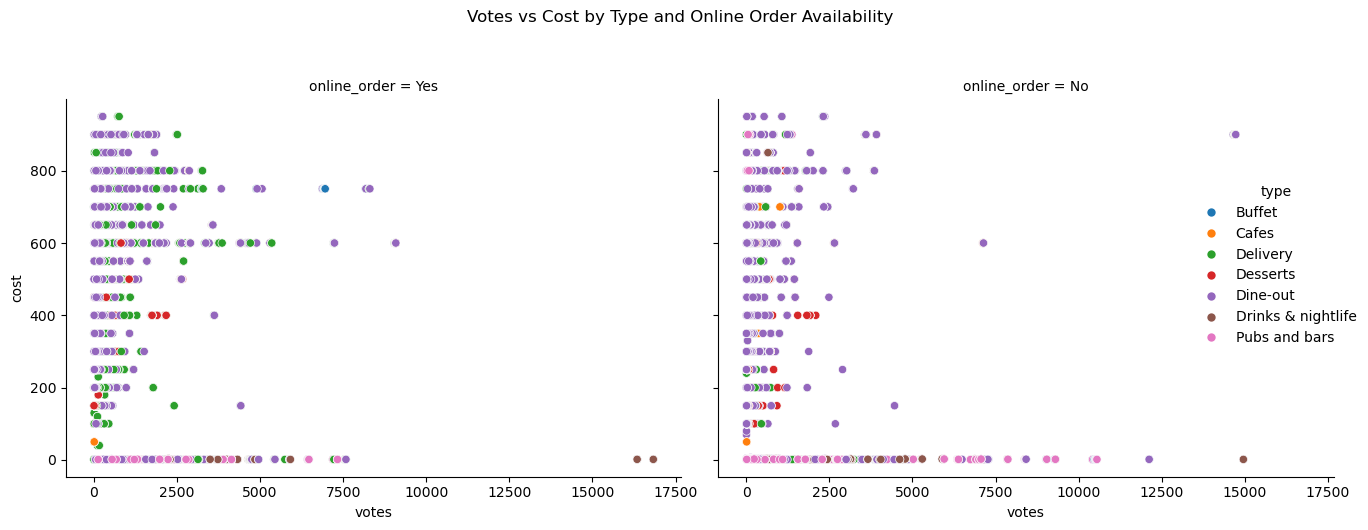

In [40]:
top_rest_types = zomato_df['rest_type'].value_counts().nlargest(10).index #filtering so that too many rows are not used
filtered_df = zomato_df[zomato_df['rest_type'].isin(top_rest_types)]
print("\nCost by Rest Type, broken down by Online Order:")
plt.figure(figsize=(14, 7))
sns.boxplot(x='rest_type', y='cost', hue='online_order', data=filtered_df)
plt.title('Cost by Rest Type and Online Order Availability')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Online Order')
plt.tight_layout()
plt.show()
print("\nVotes vs Cost, separated by Online Order and colored by Type:")
sns.relplot(
    x='votes', y='cost',
    hue='type', col='online_order',
    data=zomato_df,
    kind='scatter', height=5, aspect=1.2
)
plt.suptitle('Votes vs Cost by Type and Online Order Availability', y=1.05)
plt.tight_layout()
plt.show()

In [41]:
df_percent = zomato_df[zomato_df['rate'] > 3.5].copy()

# Clean text: fill NaN with empty string and ensure all entries are strings
df_percent.loc[:, 'reviews_list'] = df_percent['reviews_list'].fillna('').astype(str)

# Set index and prepare for similarity calculation
df_percent.set_index('name', inplace=True)
indices = pd.Series(df_percent.index)

# TF-IDF Vectorization
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=1, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_percent['reviews_list'])

# Cosine similarity
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)


In [50]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors  # This import was missing

def recommend(restaurant_name, top_n=10, df=zomato_df):
    """
    Recommend similar restaurants based on cuisines using TF-IDF and cosine similarity.
    """
    try:
        # 1. Filter dataset (optional memory optimization)
        df_subset = df[df['rate'] > 1.5].copy() if len(df) > 10000 else df.copy()
        
        # 2. Vectorize cuisines using TF-IDF
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(df_subset['cuisines'].fillna(''))
        
        # 3. Fit Nearest Neighbors
        nn = NearestNeighbors(n_neighbors=top_n+1, algorithm='brute', metric='cosine')
        nn.fit(tfidf_matrix)
        
        # 4. Index lookup
        indices = pd.Series(df_subset.index, index=df_subset['name']).drop_duplicates()
        idx = indices.get(restaurant_name)
        
        if idx is None:
            print(f"❌ Restaurant '{restaurant_name}' not found.")
            suggestions = df[df['name'].str.contains(restaurant_name.split()[0], case=False)]['name'].unique()[:5]
            print("Did you mean one of these?\n", suggestions)
            return None
        
        # 5. Get similar restaurants
        distances, neighbor_indices = nn.kneighbors(tfidf_matrix[idx])
        
        # 6. Format and return top N (excluding self)
        recommendations = df_subset.iloc[neighbor_indices[0][1:top_n+1]][
            ['name', 'cuisines', 'rate', 'cost']
        ].sort_values('rate', ascending=False)
        
        recommendations = recommendations.rename(columns={
            'name': 'Restaurant', 
            'cuisines': 'Cuisines',
            'rate': 'Mean Rating',
            'cost': 'Cost'
        })
        
        print(f"\n📍 TOP {top_n} RESTAURANTS LIKE {restaurant_name} WITH SIMILAR REVIEWS:\n")
        return recommendations
        
    except Exception as e:
        print(f"⚠️ Error: {str(e)}")
        print("Try reducing the dataset size or using a machine with more memory.")
        return None

In [51]:
recommend('Red Chilliez')


📍 TOP 10 RESTAURANTS LIKE Red Chilliez WITH SIMILAR REVIEWS:



,Restaurant,Cuisines,Mean Rating,Cost
1764,Hunger Camp,"North Indian, South Indian, Chinese, Seafood",4.6,1.3
14137,Red Chilliez,"North Indian, South Indian, Chinese, Seafood",3.6,550.0
31548,Kadai,"North Indian, Chinese, Seafood, South Indian",3.6,450.0
36049,Ideal Kitchen,"North Indian, Chinese, South Indian, Seafood",3.5,250.0
11835,Ideal Kitchen,"North Indian, Chinese, South Indian, Seafood",3.5,250.0
32212,Kudla Beach,"North Indian, South Indian, Seafood, Chinese",3.5,400.0
18437,Sea Horse,"Seafood, Chinese, South Indian, North Indian",3.4,500.0
36895,Shri Family Restaurant,"South Indian, North Indian, Chinese, Seafood",3.4,400.0
16359,Sea Horse,"Seafood, Chinese, South Indian, North Indian",3.4,500.0
1727,Hotel Annapoorna,"South Indian, Chinese, North Indian, Seafood",3.2,400.0


In [52]:
recommend("Cinnamon")


📍 TOP 10 RESTAURANTS LIKE Cinnamon WITH SIMILAR REVIEWS:



,Restaurant,Cuisines,Mean Rating,Cost
13122,Raichur Biryani House,"Biryani, North Indian, Chinese",3.8,400.0
6466,Hyderabad Cuisine Multicuisine Restaurant,"North Indian, Chinese, Biryani",3.7,700.0
40791,Hyderabad Biryaani House,"Biryani, North Indian, Chinese",3.6,700.0
950,Elegant Dining,"Biryani, North Indian, Chinese",3.6,700.0
13099,Appetite Workstation,"North Indian, Chinese, Biryani",3.6,500.0
13136,Hotel Tadaka House,"North Indian, Chinese, Biryani",3.4,300.0
6421,Chinese Chaska,"Chinese, North Indian, Biryani",3.1,550.0
13137,Half & Half Food Box,"North Indian, Chinese, Biryani",3.1,500.0
33320,Eatwell Restaurant,"North Indian, Chinese, Biryani",3.0,400.0
13131,Dande's Hyderabad Biryani,"Biryani, North Indian, Chinese",3.0,550.0


In [53]:
recommend('Spice Up')


📍 TOP 10 RESTAURANTS LIKE Spice Up WITH SIMILAR REVIEWS:



,Restaurant,Cuisines,Mean Rating,Cost
26758,China Pearl,Chinese,4.4,1.1
34124,Little Chef,Chinese,4.0,550.0
4573,Mandarin Box,Chinese,3.9,500.0
2793,Chung's Chinese Corner,Chinese,3.9,700.0
21991,Gourmet Food Truck,Chinese,3.8,200.0
17075,Flavour of China,Chinese,3.8,600.0
32612,R R Noodles Express,Chinese,3.6,300.0
21969,Chination,Chinese,3.5,600.0
11004,The Three Dragons,Chinese,3.3,400.0
32524,New Aroma,Chinese,3.3,250.0


In [54]:
recommend('Desi Doze')


📍 TOP 10 RESTAURANTS LIKE Desi Doze WITH SIMILAR REVIEWS:



,Restaurant,Cuisines,Mean Rating,Cost
6887,Gorbandh,"Fast Food, North Indian",4.0,400.0
3502,Parathabox,"Fast Food, North Indian",3.8,150.0
25891,Dilli in a Box,"Fast Food, North Indian",3.7,400.0
7112,Maa Durga Fast Food,"North Indian, Fast Food",3.6,300.0
36974,Raj Bhog,"North Indian, Fast Food",3.4,500.0
29505,Navya Foods,"North Indian, Fast Food",3.4,300.0
10286,Eatato Snack Bar,"North Indian, Fast Food",3.3,400.0
19833,Cafeteria Al - Falah,"Fast Food, North Indian",3.3,300.0
38607,KKR FOODIES,"Fast Food, North Indian",3.3,400.0
34746,KKR FOODIES,"Fast Food, North Indian",3.2,400.0


In [47]:
import pickle

# After all your preprocessing is done, save everything
with open('restaurant.pkl', 'wb') as file:
    data_to_save = {
        'df_percent': df_percent,
        'tfidf': tfidf,
        'tfidf_matrix': tfidf_matrix,
        'cosine_similarities': cosine_similarities,
        'indices': indices,
        'zomato_df': zomato_df
    }
    pickle.dump(data_to_save, file)
print("✅ Recommendation data saved to restaurant.pkl")

✅ Recommendation data saved to restaurant.pkl
